# Bank Customer Churn Prediction



In [42]:
# --- 1. Import Packages ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

import warnings
warnings.filterwarnings("ignore")



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, f1_score

In [36]:
# --- Load Data ---
df = pd.read_csv('/content/Bank_churn.csv')  # Update filename as needed
df.head()

,id,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Rating,Exited,"Geography:str,Gender:str"
0,0.0,15674932.0,"O,k{wudilic_-huk>wu_",668.0,33.0,3.0,0.00,2.0,1.0,0.0,181449.97,-3,0,"{'Geography': 'Paris-France','Gender': 'Male'}"
1,1.0,15749177.0,"O{kwudi""li#%%'oli=-sa",627.0,33.0,1.0,0.00,2.0,1.0,1.0,49503.5,0,0,"{'Geography': 'Paris-France','Gender': 'Male'}"
2,2.0,15694510.0,Hsueh,678.0,40.0,10.0,0.00,2.0,1.0,0.0,184866.69,1,0,"{'Geography': 'Paris-France','Gender': 'Male'}"
3,3.0,15741417.0,"Kao,]?>?%]@",581.0,34.0,2.0,148882.54,1.0,1.0,1.0,84560.88,-4,0,"{'Geography': 'Paris-France','Gender': 'Male'}"
4,4.0,15766172.0,Ch-i]emen'-am,716.0,33.0,5.0,0.00,2.0,1.0,1.0,15068.83,-1,0,"{'Geography': 'Madrid-Spain','Gender': 'Male'}"


In [37]:
# --- 3. Extract Geography and Gender from dict string (if present) ---
dict_colname = df.columns[-1]
if df[dict_colname].astype(str).str.startswith("{'Geography'").any():
    df[['Geography', 'Gender']] = df[dict_colname].apply(lambda x: pd.Series(ast.literal_eval(str(x))))
    df.drop(dict_colname, axis=1, inplace=True)

In [38]:
# --- 4. Remove unnecessary columns ---
for col in ['id', 'CustomerId', 'Surname']:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)

In [39]:
# --- 5. Universal numeric cleaning (handles k, typos, and text) ---
def convert_numeric_with_typos(x):
    x = str(x).strip().lower()
    typo_map = {
        'twinty': 20, 'twenty': 20, 'ten': 10, 'thirty': 30, 'forty': 40, 'one': 1,
        # add other common typo-number words here if needed
    }
    try:
        if x.endswith('k'):
            return float(x[:-1]) * 1000
        elif x in typo_map:
            return typo_map[x]
        # Remove anything after a space if not a valid float
        x_num = x.split()[0]
        return float(x_num)
    except:
        return np.nan

num_cols = [
    'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
    'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Rating'
]
for col in num_cols:
    if col in df.columns:
        df[col] = df[col].apply(convert_numeric_with_typos)

In [40]:
# --- 6. Encode Geography and Gender if needed ---
for col in ['Geography', 'Gender']:
    if col in df.columns and df[col].dtype == object:
        df[col] = LabelEncoder().fit_transform(df[col])

In [43]:
# --- 7. Fill missing values ---
for col in num_cols:
    if col in df.columns:
        df[col].fillna(df[col].median(), inplace=True)
for col in ['NumOfProducts', 'HasCrCard', 'IsActiveMember']:
    if col in df.columns:
        df[col].fillna(df[col].mode()[0], inplace=True)

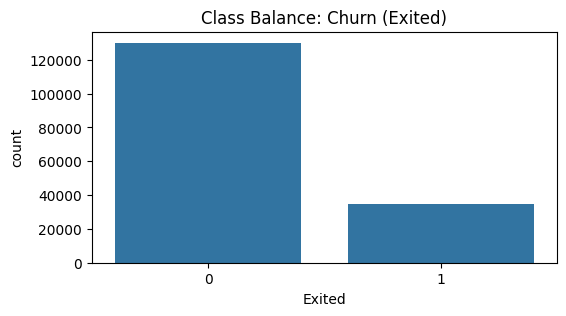

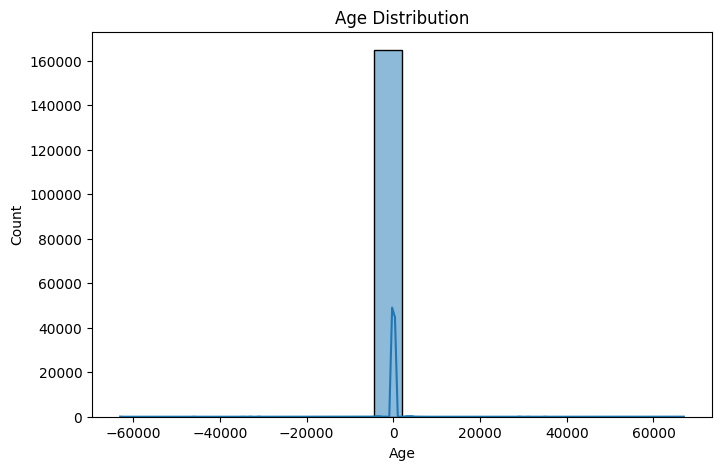

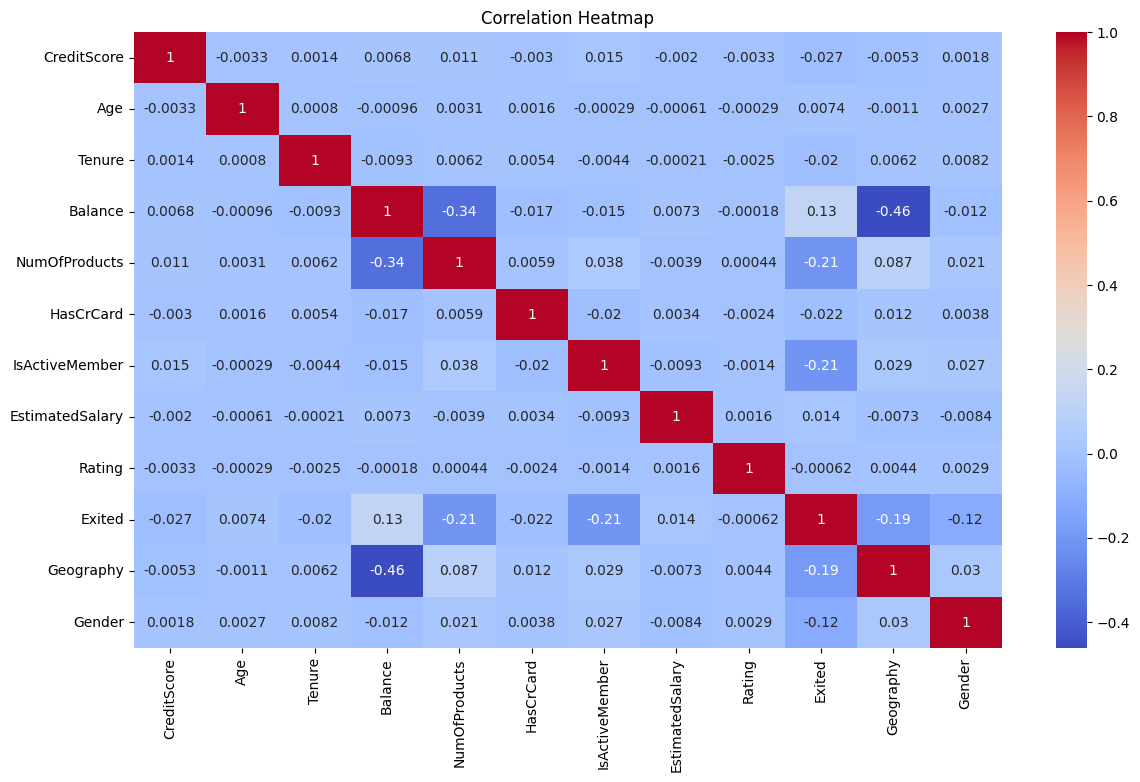

In [45]:
# --- 8. EDA ---
plt.figure(figsize=(6, 3))
sns.countplot(x='Exited', data=df)
plt.title('Class Balance: Churn (Exited)')
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.show()

plt.figure(figsize=(14, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [46]:
# --- 9. Features & Target ---
X = df.drop('Exited', axis=1)
y = df['Exited']

# --- 10. Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [47]:
# --- 11. Scale Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [48]:
# --- 12. Model Training & Evaluation ---
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    results[name] = {'Accuracy': acc, 'ROC AUC': roc_auc, 'F1 Score': f1}
    print(f"\n{name}:\nAccuracy = {acc:.3f}, ROC AUC = {roc_auc:.3f}, F1 Score = {f1:.3f}")
    print(classification_report(y_test, y_pred))


Logistic Regression:
Accuracy = 0.804, ROC AUC = 0.737, F1 Score = 0.284
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     26023
           1       0.62      0.18      0.28      6984

    accuracy                           0.80     33007
   macro avg       0.72      0.58      0.59     33007
weighted avg       0.78      0.80      0.76     33007


Random Forest:
Accuracy = 0.856, ROC AUC = 0.868, F1 Score = 0.602
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     26023
           1       0.72      0.52      0.60      6984

    accuracy                           0.86     33007
   macro avg       0.80      0.73      0.76     33007
weighted avg       0.85      0.86      0.85     33007


Gradient Boosting:
Accuracy = 0.860, ROC AUC = 0.881, F1 Score = 0.610
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     26023
           1       0.75

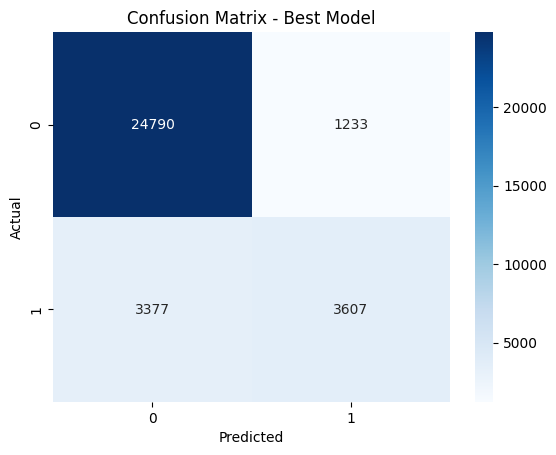

In [49]:
# --- 13. Confusion Matrix for Best Model ---
best_model = models['Gradient Boosting']  # or pick based on scores
y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Best Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

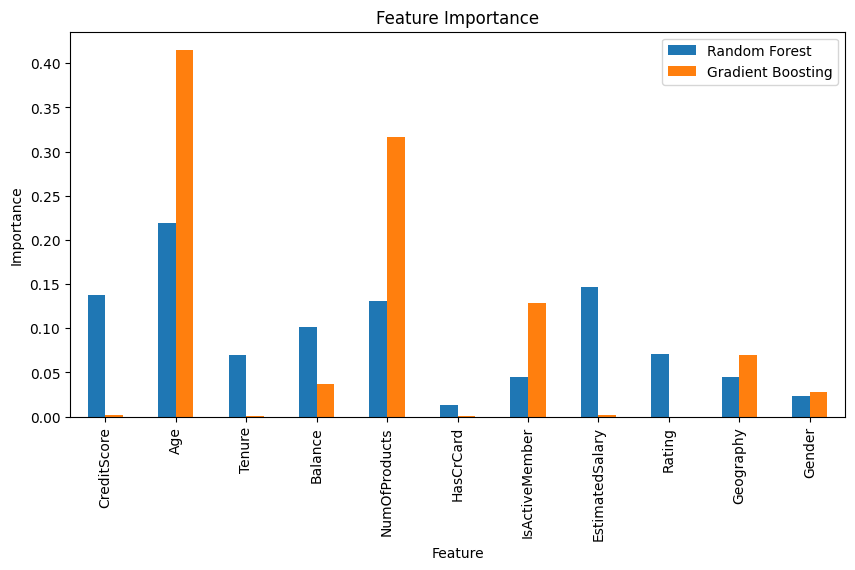

In [50]:
# --- 14. Feature Importance ---
feat_imp_df = pd.DataFrame({
    'Feature': X.columns,
    'Random Forest': models['Random Forest'].feature_importances_,
    'Gradient Boosting': models['Gradient Boosting'].feature_importances_
})
feat_imp_df.plot(x='Feature', kind='bar', figsize=(10,5))
plt.title('Feature Importance')
plt.ylabel('Importance')
plt.show()

In [51]:
# --- 15. Save Predictions ---
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_best})
results_df.to_csv('churn_predictions.csv', index=False)